In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize as so
from scipy.integrate import quad

%matplotlib inline

### First, let's generate a sample from an exponential and add Gaussian noise

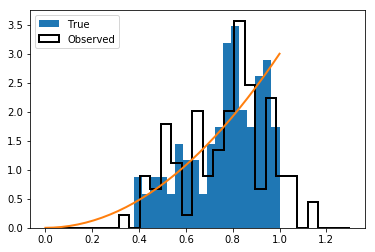

In [2]:
# Assume a constant volume sphere, with Earth at the center. 
# Then draw random distances

# P(dist) ~ dist^2
# Normalize to solve for the coefficient: P(dist) = 3/dist_max^3 * dist^2

# Draw random distances using inverse sampling
size=100
dist_max = 1.0 # in kpc
dist = (np.random.uniform(size=size))**(1.0/3.0) * dist_max

# Plot sample
bins = np.linspace(0.0, 1.0, 30)
plt.hist(dist, bins=bins, normed=True, label='True')

# Plot analytic
plt.plot(bins, 3.0 * bins**2 * dist_max**-3, linewidth=2.0)

# Now add uncertainties of 100 pc
dist_obs = dist + np.random.normal(size=size, scale=0.1)
# Array of errors
dist_err = 0.1 * np.ones(len(dist_obs))


bins = np.linspace(0.0, 1.3, 30)
plt.hist(dist_obs, bins=bins, normed=True, histtype='step', 
         linewidth=2.0, color='k', label='Observed')


plt.legend(loc=2)

plt.show()

### First, let's see if we can recover the exponential in the power law. We will start with the true distances

In [27]:
# This is the normalized pdf for arbitrary alpha
def func_pdf(alpha, x_max, x):
    P_x = (alpha) * x**(alpha-1.0) * dist_max**(-alpha)
    P_x[x>x_max] = 0.0 
    P_x[x<0.0] = 0.0
    return P_x

def ln_prior(alpha):
    if alpha < 0.0:
        return -np.inf
    
    return 0.0


def ln_likelihood(alpha, x_max, x_obs):
    return np.sum(np.log(func_pdf(alpha, x_max, x_obs)))


def ln_posterior(alpha, x_max, x_obs):
    
    lp = ln_prior(alpha)
    ll = ln_likelihood(alpha, x_max, x_obs)
        
    return lp+ll


def neg_ln_posterior(alpha, x_max, x_obs):
    return -ln_posterior(alpha, x_max, x_obs)

In [28]:
# We will give it the wrong starting value
p0 = 1.0

res = so.minimize(neg_ln_posterior, p0, args=(1.0, dist))
if res.success:
    print("Expected result: 3.0")
    print("Result:", res.x)
else:
    print("Optimization failed")

Expected result: 3.0
Result: [ 3.36201915]


### Now, let's see if we can account for the uncertainties

In [16]:
# This is the normalized pdf for arbitrary alpha
def func_pdf(alpha, x_max, x):
    P_x = (alpha) * x**(alpha-1.0) * dist_max**(-alpha)
    
    if type(x) is np.ndarray:
        P_x[x>x_max] = 0.0 
        P_x[x<0.0] = 0.0
    elif x>x_max:
        return 0.0
    elif x<0.0:
        return 0.0
    else:
        pass
        
    return P_x

def func_integrand(x, alpha, x_max, x_obs, x_err):
    return stats.norm.pdf(x, loc=x_obs, scale=x_err) * func_pdf(alpha, x_max, x)

def ln_prior(alpha):
    if alpha < 0.0:
        return -np.inf
    
    return 0.0


def ln_likelihood(alpha, x_max, x_obs, x_err):
    
    ln_likelihood = 0.0
    for i in range(len(x_obs)):
        
        # Limits are either the limits of the pdf or 5 sigma from the observed value
        a = max(0.0, x_obs[i]-3.0*x_err[i])
        b = min(x_max, x_obs[i]+3.0*x_err[i])
        
        val = quad(func_integrand, a, b, args=(alpha, x_max, x_obs[i], x_err[i]), 
                   epsrel=1.0e-4, epsabs=1.0e-4)
        ln_likelihood += np.log(val[0])
    
    return ln_likelihood


def ln_posterior(alpha, x_max, x_obs, x_err):
    
    lp = ln_prior(alpha)
    ll = ln_likelihood(alpha, x_max, x_obs, x_err)
                        
    return lp+ll


def neg_ln_posterior(alpha, x_max, x_obs, x_err):
    return -ln_posterior(alpha, x_max, x_obs, x_err)

In [17]:
# We will give it the wrong starting value
p0 = 6.0
dist_max = 1.0

res = so.minimize(neg_ln_posterior, p0, args=(dist_max, dist_obs, dist_err))
if res.success:
    print("Expected result: 3.0")
    print("Result:", res.x)
else:
    print("Optimization failed")

Expected result: 3.0
Result: [ 3.51069161]
